## Translating Wikidata queries to DBpedia with LLMs chain of thought (CoT) model with "think" tag

In [2]:
# import libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

In [2]:
# Load the dataset from 100_complete_entries_wikidata.json
with open("../../../data/100_complete_entries_wikidata.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")
    wikidata_query = entry.get("wikidata_query", "")
    
    # Extract entities and relations (ER2) in DBpedia
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["dbpedia_id"]
    ]
    
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": wikidata_query,
            "kg1_name": "Wikidata",
            "kg2_name": "DBpedia",
            "er2": er2,
            "instruction": (
                """
                Given the information above, produce a SPARQL query for KG2.
                
                <think> Identify the key entities and relations in the given question. Use the provided 'er2' mappings to directly map them from Wikidata to DBpedia. </think>
                
                <think> Analyze the structure of the Wikidata SPARQL query to understand how the information is retrieved. Identify the query pattern. </think>
                
                <think> Find the equivalent properties in DBpedia using the mapped entities and relations. If no direct equivalent exists, determine the closest alternative. </think>
                
                <think> Construct the SPARQL query using DBpedia syntax while maintaining the logical structure of the Wikidata query. </think>
                
                <think> Validate the final query by ensuring all entities, relationships, and query logic align with DBpedia's data model. </think>
                
                Then, provide the final, complete SPARQL query enclosed within the tags '<sparql>' and '</sparql>'.
                """
            )
        }
    }    
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("CoT_input_wikidata_dbpedia_think.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print("Processed dataset saved to 'CoT_input_wikidata_dbpedia_think.json'.")


Processed dataset saved to 'CoT_input_wikidata_dbpedia_think.json'.


## Running llama-3.1-8b-instruct
**meta-llama-3.1-8b-instruct is the smallest available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 8billion parameters**

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("CoT_input_wikidata_dbpedia_think.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("CoT_output_llama_wikidata_dbpedia_think.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'CoT_output_llama_wikidata_dbpedia_think.json'.")


Translated SPARQL queries for all questions saved to 'CoT_output_llama_wikidata_dbpedia_think.json'.


## Running Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("CoT_input_wikidata_dbpedia_think.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("CoT_output_mistral_wikidata_dbpedia_think.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'CoT_output_mistral_wikidata_dbpedia_think.json'.")

Translated SPARQL queries for all questions saved to 'CoT_output_mistral_wikidata_dbpedia_think.json'.


## Running DeepSeek R1 100 queries
Using DeepSeek R1 distill llama 70B for translating the queries from DBpedia to Wikidata.
**DeepSeek R1 distill llama 70B available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 70 billion parameters**

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "deepseek-r1-distill-llama-70b"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("CoT_input_wikidata_dbpedia_think.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("CoT_output_deepseek_wikidata_dbpedia_think.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'CoT_output_deepseek_wikidata_dbpedia_think.json'.")


Translated SPARQL queries for all questions saved to 'CoT_output_deepseek_wikidata_dbpedia_think.json'.


## Analysis of the results

Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [16]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments marked with #
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    Also calculates statistics on the extraction process.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if natural_language_question and final_sparql_query:
            cleaned_entry = {
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            }
            cleaned_data.append(cleaned_entry)
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    # Save the successfully extracted queries to a new JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Print statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0
    
    print(f"Processed {total_entries} entries and saved to {output_file}.")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count}")
    print(f"Extraction success rate: {success_rate:.2f}%")
    
    
if __name__ == "__main__":
    input_filename = "CoT_output_mistral_wikidata_dbpedia_think.json"
    output_filename = "CoT_mistral_wikidata_dbpedia_extracted_think.json"
    process_input_file(input_filename, output_filename)


Processed 100 entries and saved to CoT_mistral_wikidata_dbpedia_extracted_think.json.
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output for **llama-3.1-8b-instruct**.

In [7]:
input_file_path = 'CoT_output_llama_wikidata_dbpedia_think.json'
output_file_path = 'CoT_llama_wikidata_dbpedia_extracted_think.json'

def extract_and_clean_sparql_query(sparql_raw):
    try:
        # 1. Try to extract all SPARQL blocks enclosed in <sparql> ... </sparql> (case-insensitive)
        matches = re.findall(r"<sparql>(.*?)</sparql>", sparql_raw, re.DOTALL | re.IGNORECASE)
        if matches:
            query = matches[-1]  # choose the last occurrence
        else:
            # 2. If not found, try to extract all triple-backtick blocks with 'sparql'
            matches = re.findall(r"```sparql\s*(.*?)\s*```", sparql_raw, re.DOTALL | re.IGNORECASE)
            if matches:
                query = matches[-1]
            else:
                # 3. As a fallback, look for queries that start with PREFIX and contain a WHERE clause
                matches = re.findall(r"(PREFIX.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL | re.IGNORECASE)
                if matches:
                    query = matches[-1]
                else:
                    # 4. Another fallback: try capturing any SELECT query that contains a WHERE clause
                    matches = re.findall(r"(SELECT\s+.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL | re.IGNORECASE)
                    if matches:
                        query = matches[-1]
                    else:
                        return None  # No query found

        # Remove any leftover markers (e.g. triple-backticks or <sparql> tags)
        query = re.sub(r"```sparql|```|<sparql>|</sparql>", "", query, flags=re.IGNORECASE)
        # Remove comments (lines starting with #)
        query = re.sub(r"# .*", "", query)
        # Remove all newlines and extra whitespace so that the query becomes a single line
        query = re.sub(r"\s+", " ", query).strip()

        return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
        return None

# Initialize results tracking
result = []
failed_queries = []
extracted_count = 0

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

total_entries = len(data)

# Process all entries and pair the natural language question with the cleaned SPARQL query
for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question')
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Print extraction statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to CoT_llama_wikidata_dbpedia_extracted_think.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output from **Deep Seek R1**.

In [8]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments marked with #
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file, failed_output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    Also saves failed extractions to a separate file and calculates statistics.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if natural_language_question and final_sparql_query:
            cleaned_entry = {
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            }
            cleaned_data.append(cleaned_entry)
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    # Save the successfully extracted queries to a new JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Save the failed queries to a separate JSON file
    with open(failed_output_file, "w", encoding="utf-8") as f:
        json.dump(failed_queries, f, indent=2)
    
    # Print statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0
    
    print(f"Processed {total_entries} entries and saved to {output_file}.")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count} (saved in {failed_output_file})")
    print(f"Extraction success rate: {success_rate:.2f}%")
    
if __name__ == "__main__":
    input_filename = "CoT_output_deepseek_wikidata_dbpedia_think.json"
    output_filename = "CoT_deepseek_wikidata_dbpedia_extracted_think.json"
    failed_output_filename = "failed_queries.json"
    process_input_file(input_filename, output_filename, failed_output_filename)

Processed 100 entries and saved to CoT_deepseek_wikidata_dbpedia_extracted_think.json.
Successfully extracted queries: 100
Failed queries: 0 (saved in failed_queries.json)
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on DBpedia 
Results for **mistral-large-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix rdfs was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 2,\n        "positionInLine": 175,\n        "query": "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\\nPREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri dbo:launchSite dbr:Baikonur_Cosmodrome . ?uri rdf:type/rdfs:subClassOf* dbo:Rocket . }",\n        "startIndex": 233,\n        "stopIndex": 247\n    },\n    "query": "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\\nPREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri dbo:launchSite dbr:Baikonur_Cosmodrome . ?uri rdf:type/rdfs:subClassOf* dbo:Rocket . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {

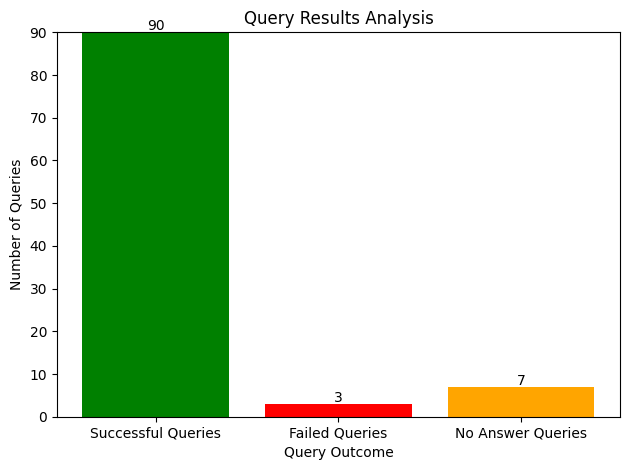

In [3]:
# File paths
input_file_path = "CoT_mistral_wikidata_dbpedia_extracted_think.json"
output_file_path = "CoT_mistral_wikidata_dbpedia_executed_think.json"

# DBpedia local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
"""


# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    required_prefixes = [
        "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>",
        "PREFIX dbo: <http://dbpedia.org/ontology/>",
        "PREFIX dbr: <http://dbpedia.org/resource/>",
    ]
    
    missing_prefixes = [p for p in required_prefixes if p not in query]
    
    # Ensure the missing prefixes are added to the top
    if missing_prefixes:
        query = "\n".join(missing_prefixes) + "\n" + query
    
    return query



# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"Bundesliga\\": extraneous input \'Bundesliga\' expecting {\'(\', \'{\', \'}\', \'[\', \'true\', \'false\', SELECT, VALUES, GRAPH, OPTIONAL, SERVICE, BIND, MINUS, FILTER, IRI_REF, PNAME_NS, PNAME_LN, BLANK_NODE_LABEL, VAR1, VAR2, PREFIX_LANGTAG, INTEGER, DECIMAL, DOUBLE, INTEGER_POSITIVE, DECIMAL_POSITIVE, DOUBLE_POSITIVE, INTEGER_NEGATIVE, DECIMAL_NEGATIVE, DOUBLE_NEGATIVE, STRING_LITERAL1, STRING_LITERAL2, STRING_LITERAL_LONG1, STRING_LITERAL_LONG2, NIL, ANON}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 156,\n        "query": "PREFIX dbp: <http://dbpedia.org/ontology/> PREFIX db: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri dbp:class db:Club ; dbp:partOf db:{{{Bundesliga}}}. }",\n        "startIndex": 156,\n        "stopIndex": 165\n    },\n    "query": "PREFIX

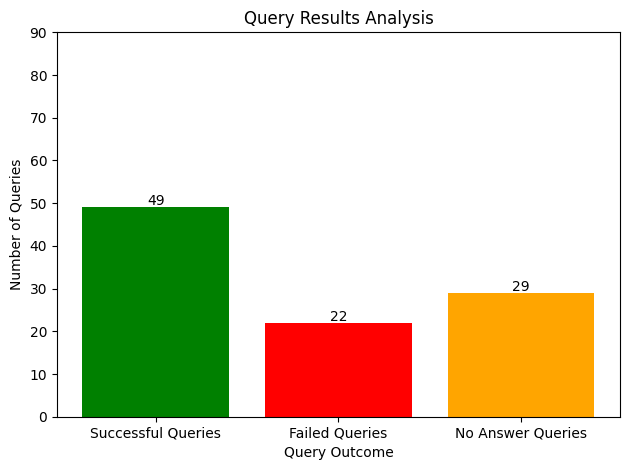

In [4]:
# File paths
input_file_path = "CoT_llama_wikidata_dbpedia_extracted_think.json"
output_file_path = "CoT_llama_wikidata_dbpedia_executed_think.json"

# DBpedia local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **Deep Seek R1**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Not supported: FROM clauses are currently not supported by QLever.",\n    "metadata": {\n        "line": 4,\n        "positionInLine": 121,\n        "query": "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\\nPREFIX dbo: <http://dbpedia.org/ontology/>\\nPREFIX dbr: <http://dbpedia.org/resource/>\\nPREFIX dbpedia: <http://dbpedia.org/> PREFIX dbpedia-owl: <http://dbpedia.org/ontology/> SELECT DISTINCT ?uri ?elevation FROM <http://dbpedia.org/sparql> WHERE { ?uri rdf:type dbpedia-owl:Mountain ; dbpedia-owl:locatedInArea dbpedia:Italy ; dbpedia-owl:elevation ?elevation . } ORDER BY DESC(?elevation) LIMIT 1",\n        "startIndex": 265,\n        "stopIndex": 296\n    },\n    "query": "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\\nPREFIX dbo: <http://dbpedia.org/ontology/>\\nPREFIX dbr: <http://dbpedia.org/resource/>

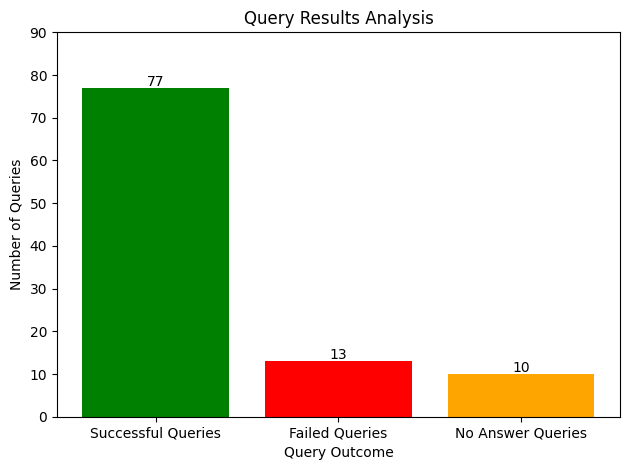

In [5]:
# File paths
input_file_path = "CoT_deepseek_wikidata_dbpedia_extracted_think.json"
output_file_path = "CoT_deepseek_wikidata_dbpedia_executed_think.json"

# DBpedia local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
"""


# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    required_prefixes = [
        "PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>",
        "PREFIX dbo: <http://dbpedia.org/ontology/>",
        "PREFIX dbr: <http://dbpedia.org/resource/>",
    ]
    
    missing_prefixes = [p for p in required_prefixes if p not in query]
    
    # Ensure the missing prefixes are added to the top
    if missing_prefixes:
        query = "\n".join(missing_prefixes) + "\n" + query
    
    return query



# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

## Comparison of DBpedia output with gold label output
In the following the final output of querying DBpedia is compared to the original output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

Comparison completed. Results saved to 'CoT_llama_wikidata_dbpedia_results_comparison_think.xlsx'.
Total Queries: 100
Correct Queries: 47
Incorrect Queries (executed but wrong answer): 2
Query Failed to execute: 22
No Answer Queries (executed but empty answer): 29
Accuracy: 47.00%
Execution Success Rate (ESR): 49.00%


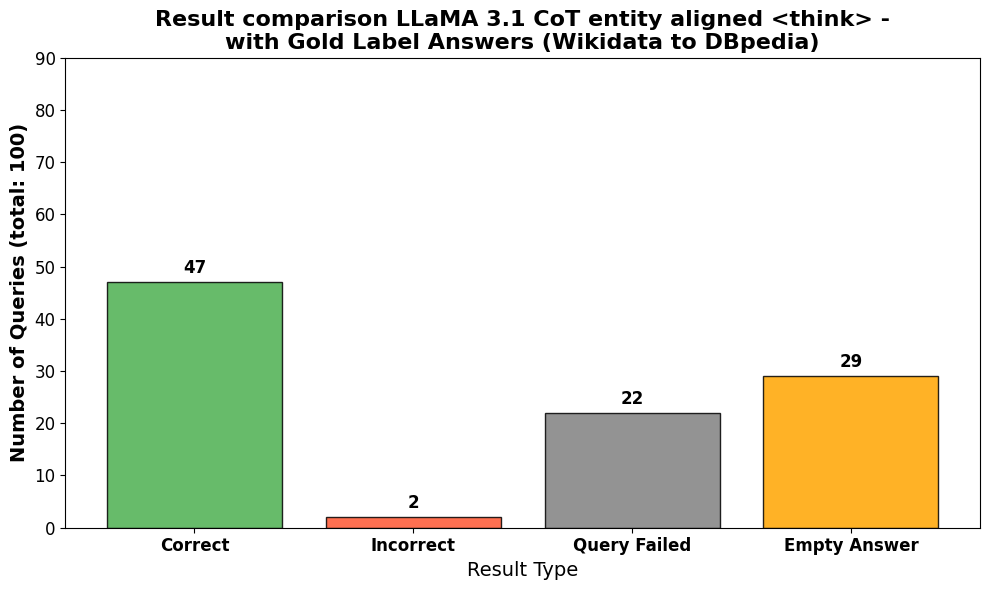

In [6]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "CoT_llama_wikidata_dbpedia_executed_think.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results and list to hold failed/empty queries
comparison_results = []
failed_or_empty_entries = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Initialize counters
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

# Compare answers and also collect failed queries
for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Check for failed queries or empty answers and save them
    if "Query failed" in lama_answers:
        query_failed_count += 1
        failed_or_empty_entries.append(lama_entry)
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        failed_or_empty_entries.append(lama_entry)
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if the expected answers match the LLM output answers (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if lama_answers and "Query failed" not in lama_answers:
        successful_executions += 1

# Save the comparison results to an Excel file for review
output_excel_file = "CoT_llama_wikidata_dbpedia_results_comparison_think.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy and execution success rate (ESR)
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

plt.title('Result comparison LLaMA 3.1 CoT entity aligned <think> -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 90)

plt.tight_layout()
plt.show()

### Comparison mistral-large-instruct with original output

Comparison completed. Results saved to 'CoT_mistral_wikidata_dbpedia_results_comparison_think.xlsx'.
Total Queries: 100
Correct Queries: 79
Incorrect Queries (executed but wrong answer): 11
Query Failed to execute: 3
No Answer Queries (executed but empty answer): 7
Accuracy: 79.00%
Execution Success Rate (ESR): 90.00%


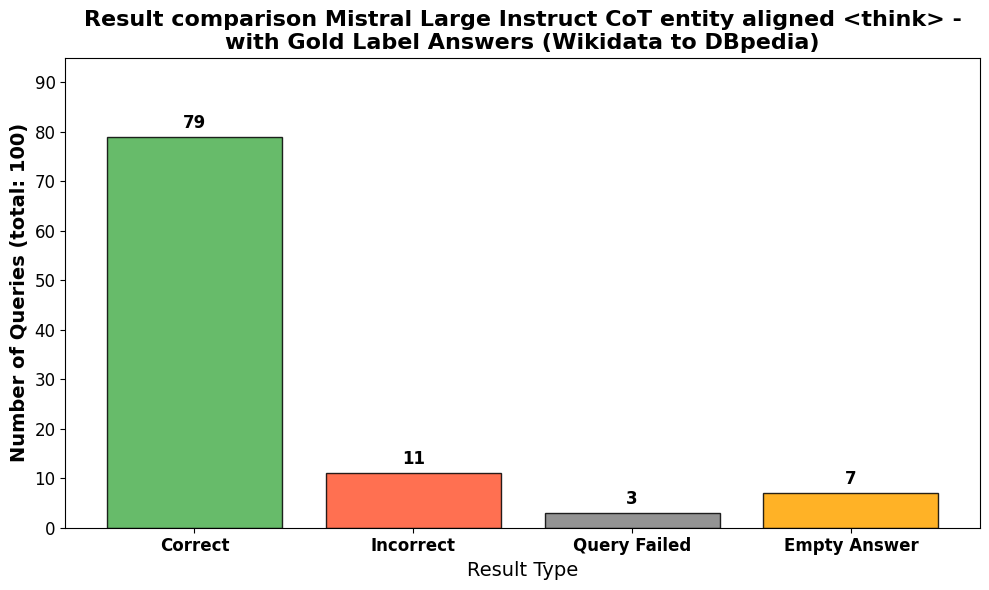

In [7]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
mistral_output_file_path = "CoT_mistral_wikidata_dbpedia_executed_think.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r') as f:
    mistral_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Compare answers
total_questions = len(mistral_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question")
    mistral_answers = mistral_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in mistral_answers:
        query_failed_count += 1
        continue
    if "No answer" in mistral_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(mistral_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "mistral_answers": mistral_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if mistral_answers and "Query failed" not in mistral_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "CoT_mistral_wikidata_dbpedia_results_comparison_think.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison Mistral Large Instruct CoT entity aligned <think> -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 95)

# Show the plot
plt.tight_layout()
plt.show()

### Comparison Deep Seek with original output

Comparison completed. Results saved to 'CoT_deepseek_wikidata_dbpedia_results_comparison_think.xlsx'.
Total Queries: 100
Correct Queries: 69
Incorrect Queries (executed but wrong answer): 8
Query Failed to execute: 13
No Answer Queries (executed but empty answer): 10
Accuracy: 69.00%
Execution Success Rate (ESR): 77.00%


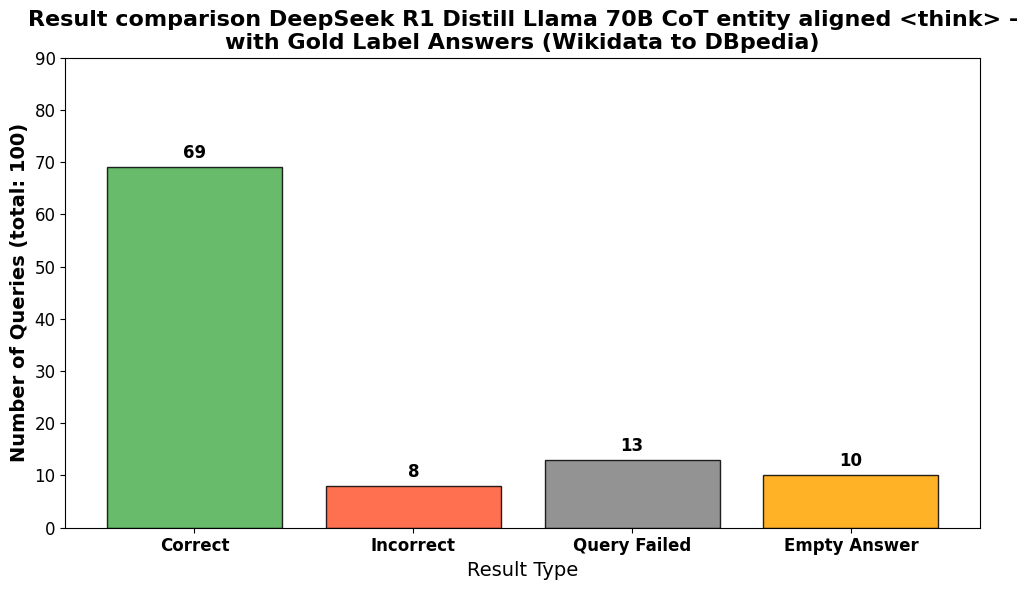

In [8]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
deepseek_output_file_path = "CoT_deepseek_wikidata_dbpedia_executed_think.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(deepseek_output_file_path, 'r') as f:
    deepseek_output_data = json.load(f)

# Initialize comparison results and list to hold failed/empty queries
comparison_results = []
failed_or_empty_entries = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Initialize counters
total_questions = len(deepseek_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

# Compare answers and also collect failed queries
for deepseek_entry in deepseek_output_data:
    question = deepseek_entry.get("natural_language_question")
    deepseek_answers = deepseek_entry.get("answers", [])

    # Check for failed queries or empty answers and save them
    if "Query failed" in deepseek_answers:
        query_failed_count += 1
        failed_or_empty_entries.append(deepseek_entry)
        continue
    if "No answer" in deepseek_answers:
        no_answer_count += 1
        failed_or_empty_entries.append(deepseek_entry)
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if the expected answers match the LLM output answers (ignoring order)
        is_correct = set(expected_answers) == set(deepseek_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "deepseek_answers": deepseek_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if deepseek_answers and "Query failed" not in deepseek_answers:
        successful_executions += 1

# Save the comparison results to an Excel file for review
output_excel_file = "CoT_deepseek_wikidata_dbpedia_results_comparison_think.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy and execution success rate (ESR)
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

plt.title('Result comparison DeepSeek R1 Distill Llama 70B CoT entity aligned <think> -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 90)

plt.tight_layout()
plt.show()

In [9]:
import sys
import os

# Get the absolute path of the current working directory
current_dir = os.getcwd()

# Go two levels up to find the 'sparql_evaluation' folder
parent_dir = os.path.abspath(os.path.join(current_dir, "../../"))

# Set the project root manually as a fallback (adjust if necessary)
manual_project_root = os.path.abspath("Meine Ablage/Master Thesis/SPARQL-Query-Translation-QALD9/QALD9-Plus-testing")

# Ensure both paths are in sys.path
sys.path.append(parent_dir)
sys.path.insert(0, manual_project_root)

# Import the function
try:
    from sparql_evaluation.evaluate_dbpedia import evaluate_dbpedia_queries
    print("Import successful!")
except ModuleNotFoundError as e:
    print("Import failed:", e)

Import successful!


In [10]:
evaluate_dbpedia_queries(
    input_file="CoT_llama_wikidata_dbpedia_extracted_think.json",
    output_excel="CoT_llama_dbpedia_think_results_analysis.xlsx",
    query_key="sparql_query"
)

In [11]:
evaluate_dbpedia_queries(
    input_file="CoT_mistral_wikidata_dbpedia_extracted_think.json",
    output_excel="CoT_mistral_dbpedia_think_results_analysis.xlsx",
    query_key="sparql_query_kg2"
)

In [12]:
evaluate_dbpedia_queries(
    input_file="CoT_deepseek_wikidata_dbpedia_extracted_think.json",
    output_excel="CoT_deepseek_dbpedia_think_results_analysis.xlsx",
    query_key="sparql_query_kg2"
)